In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import k_clique_communities
import sklearn as sk

sgs1 ="4932.YMR190C"

In [49]:
def graph_info(G0):
    # contains_SGS1 = None
    # contains_SGS1 = G0[sgs1] is not None
    print("Nodes:", G0.number_of_nodes(), "Edges:", G0.number_of_edges(), "Connected:", nx.connected.is_connected(G0), "Subgrahs:", nx.connected.number_connected_components(G0))#, "Contains SGS1:", contains_SGS1, "SGS1 degree:", G0.degree(sgs1))

In [12]:
G0 = nx.read_weighted_edgelist("4932.protein.links.v12.0.txt", comments="#", nodetype=str)
graph_info(G0)

Nodes: 6538 Edges: 1412421 Connected: True Subgrahs: 1 Contains SGS1: True SGS1 degree: 1303


In [13]:
threshhold_score = 900

for edge in G0.edges():
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0]<= threshhold_score):
        G0.remove_edge(edge[0],edge[1])
graph_info(G0)

Nodes: 6538 Edges: 52556 Connected: False Subgrahs: 1972 Contains SGS1: True SGS1 degree: 72


In [14]:
G = G0.subgraph(max(nx.connected_components(G0),key=len))
graph_info(G)

Nodes: 4294 Edges: 52179 Connected: True Subgrahs: 1 Contains SGS1: True SGS1 degree: 72


What is clique percolation?
- finds overlapping communities in network

How does it do this?
- First detects communities/cliques of size k
- Creates a clique graph
- Each community is represented by each connected commponent in the clique graph

Issues:
- All the communities will be of fixed size k
- eg. k = 3 is just triangle formations, k = 4 is a fully connected 4 node clique
- will need to find the critical k value for the communities of the graph

Critical k finding based off of:
https://arxiv.org/pdf/cond-mat/0610298 

12
finished community
check 1
check 2
check 3
12
13
finished community
check 1
check 2
check 3
13
14
finished community
check 1
check 2
check 3
14
15
finished community
check 1
check 2
check 3
15
16
finished community
check 1
check 2
check 3
16


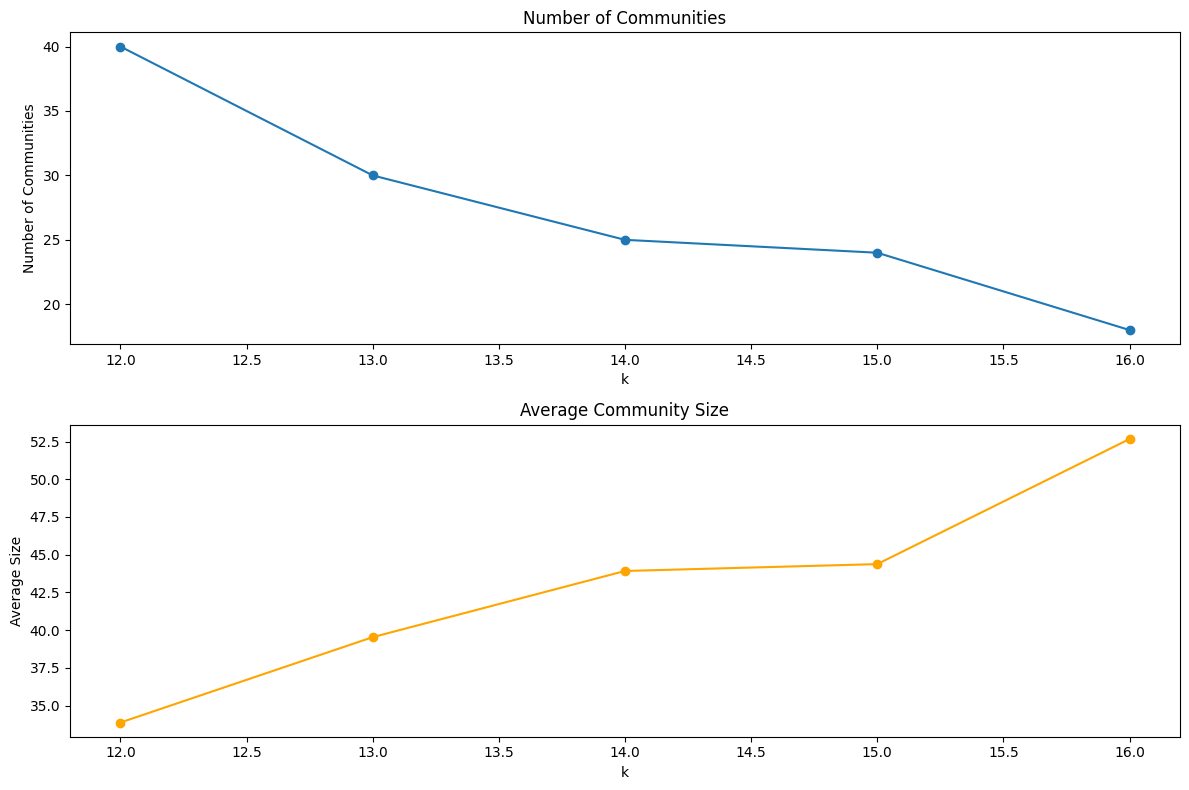

In [19]:
def calculate_metrics(G, communities, k):
    num_communities = len(communities)
    
    if num_communities == 0:
        return {
            'k': k,
            'num_communities': 0,
            'avg_size': 0,
        }
    
    community_sizes = [len(c) for c in communities]
    avg_size = np.mean(community_sizes)

    labels = np.zeros(G.number_of_nodes())
    node_to_index = {node: idx for idx, node in enumerate(G.nodes())}
    for i, community in enumerate(communities):
        for node in community:
            labels[node_to_index[node]] = i
    print("check 3")
    return {
        'k': k,
        'num_communities': num_communities,
        'avg_size': avg_size,
    }

k_values = range(12,17,1)
metrics = []

for k in k_values:
    print(k)
    communities = list(k_clique_communities(G, k))
    print("finished community")
    metrics.append(calculate_metrics(G, communities, k))

num_communities = [m['num_communities'] for m in metrics]
avg_size = [m['avg_size'] for m in metrics]

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(k_values, num_communities, marker='o')
plt.title('Number of Communities')
plt.xlabel('k')
plt.ylabel('Number of Communities')

plt.subplot(2, 1, 2)
plt.plot(k_values, avg_size, marker='o', color='orange')
plt.title('Average Community Size')
plt.xlabel('k')
plt.ylabel('Average Size')

plt.tight_layout()
plt.show()

using k = 14 (did a search for 5,10,15,20,...,+5,...100 and 15 was the elbow point)

In [38]:
k = 14

G0 = nx.read_weighted_edgelist("4932.protein.links.v12.0.txt", comments="#", nodetype=str)

threshhold_score = 900
for edge in G0.edges():
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0]<= threshhold_score):
        G0.remove_edge(edge[0],edge[1])

G = G0.subgraph(max(nx.connected_components(G0),key=len))

communities = k_clique_communities(G, k)

centrality_measures = {}

for i, community in enumerate(communities):
    subgraph = G.subgraph(community)  # Subgraph for each community

    # Calculate centralities
    degree_centrality = nx.degree_centrality(subgraph)
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    closeness_centrality = nx.closeness_centrality(subgraph)
    eigenvector_centrality = nx.eigenvector_centrality(subgraph)
    pagerank_centrality = nx.pagerank(subgraph)
    harmonic_centrality = nx.harmonic_centrality(subgraph)

    # Combine results into a centrality score
    centrality_combined = {
        node: (
            degree_centrality.get(node, 0) +
            betweenness_centrality.get(node, 0) +
            closeness_centrality.get(node, 0) +
            eigenvector_centrality.get(node, 0) +
            pagerank_centrality.get(node, 0) +
            harmonic_centrality.get(node, 0)
        ) for node in subgraph.nodes()
    }

    # Find the most central node (protein) in the community
    most_central_protein = max(centrality_combined, key=centrality_combined.get)

    centrality_measures[i] = {
        "most_central_protein": most_central_protein,
        "degree_centrality": degree_centrality.get(most_central_protein, 0),
        "betweenness_centrality": betweenness_centrality.get(most_central_protein, 0),
        "closeness_centrality": closeness_centrality.get(most_central_protein, 0),
        "eigenvector_centrality": eigenvector_centrality.get(most_central_protein, 0),
        "pagerank_centrality": pagerank_centrality.get(most_central_protein, 0),
        "harmonic_centrality": harmonic_centrality.get(most_central_protein, 0),
    }

# Output the most central protein for each community
for community_idx, data in centrality_measures.items():
    print(f"Community {community_idx}:")
    print(f"Most Central Protein: {data['most_central_protein']}")
    print(f"Degree Centrality: {data['degree_centrality']}")
    print(f"Betweenness Centrality: {data['betweenness_centrality']}")
    print(f"Closeness Centrality: {data['closeness_centrality']}")
    print(f"Eigenvector Centrality: {data['eigenvector_centrality']}")
    print(f"PageRank Centrality: {data['pagerank_centrality']}")
    print(f"Harmonic Centrality: {data['harmonic_centrality']}")
    print()

Community 0:
Most Central Protein: 4932.YKL196C
Degree Centrality: 1.0
Betweenness Centrality: 0.006433078895484911
Closeness Centrality: 1.0
Eigenvector Centrality: 0.22440104107577244
PageRank Centrality: 0.047903537701149954
Harmonic Centrality: 22.0

Community 1:
Most Central Protein: 4932.YDR190C
Degree Centrality: 1.0
Betweenness Centrality: 0.0
Closeness Centrality: 1.0
Eigenvector Centrality: 0.25819888974716115
PageRank Centrality: 0.06705022333603032
Harmonic Centrality: 14.0

Community 2:
Most Central Protein: 4932.YML114C
Degree Centrality: 1.0
Betweenness Centrality: 0.0
Closeness Centrality: 1.0
Eigenvector Centrality: 0.25819888974716115
PageRank Centrality: 0.06673828689192508
Harmonic Centrality: 14.0

Community 3:
Most Central Protein: 4932.YDR190C
Degree Centrality: 1.0
Betweenness Centrality: 0.0034927061242850718
Closeness Centrality: 1.0
Eigenvector Centrality: 0.22036800204329154
PageRank Centrality: 0.04829493412894861
Harmonic Centrality: 21.0

Community 4:
Mos

In [35]:
print(centrality_measures.items())

dict_items([])


In [51]:
k = 14

G0 = nx.read_weighted_edgelist("4932.protein.links.v12.0.txt", comments="#", nodetype=str)

threshhold_score = 900
for edge in G0.edges():
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0]<= threshhold_score):
        G0.remove_edge(edge[0],edge[1])

G = G0.subgraph(max(nx.connected_components(G0),key=len))

communities = k_clique_communities(G, k)

# Create a new graph for communities
community_graph = nx.Graph()

# Add nodes for each community
for i, community in enumerate(communities):
    community_graph.add_node(i, members=community)

# Add edges between communities based on shared nodes
for i, comm_i in enumerate(communities):
    for j, comm_j in enumerate(communities):
        if i < j:
            shared_nodes = comm_i.intersection(comm_j)
            if shared_nodes:
                print(f"Adding edge between community {i} and {j} with {len(shared_nodes)} shared nodes")
                community_graph.add_edge(i, j, weight=len(shared_nodes))


In [52]:
graph_info(community_graph)

Nodes: 25 Edges: 0 Connected: False Subgrahs: 25


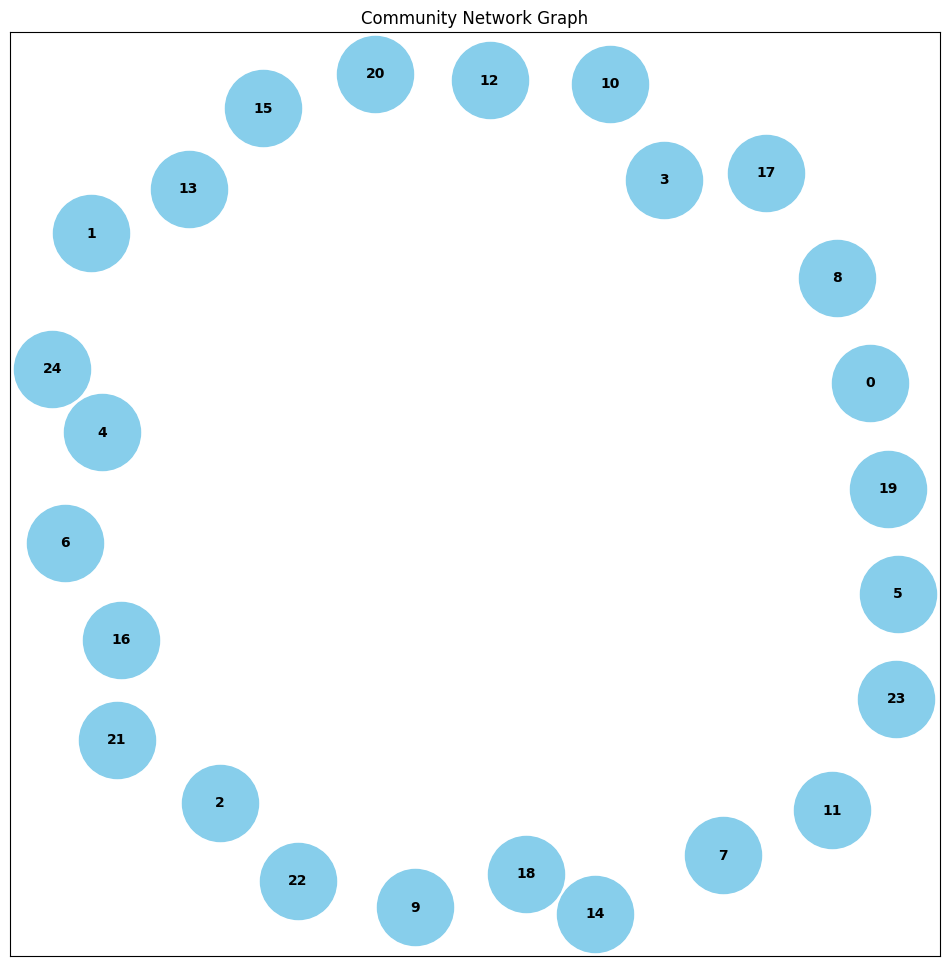

In [43]:
pos = nx.spring_layout(community_graph)
plt.figure(figsize=(12, 12))
nx.draw(community_graph, pos, node_size=3000, node_color='skyblue', width=10, edge_color='gray')
nx.draw_networkx_labels(community_graph, pos, font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(community_graph, 'weight')
nx.draw_networkx_edge_labels(community_graph, pos, edge_labels=labels)
plt.title('Community Network Graph')
plt.show()